In [41]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt

In [42]:
nlp = spacy.load('en_core_web_sm')

with open('brennu-njals_saga.en.txt', 'r', encoding='utf-8') as file:
    book_text = file.read()

doc = nlp(book_text)

In [43]:
characters = []

for entity in doc.ents:
    if entity.label_ == 'PERSON':  # Consider only the entities labeled as persons
        characters.append(entity.text)


In [44]:
G = nx.Graph()

for character in characters:
    G.add_node(character)


In [45]:
for sentence in doc.sents:
    sentence_characters = []

    for entity in sentence.ents:
        if entity.label_ == 'PERSON':
            sentence_characters.append(entity.text)

    for i, character1 in enumerate(sentence_characters):
        for character2 in sentence_characters[i + 1:]:
            if G.has_edge(character1, character2):
                G[character1][character2]['weight'] += 1
            else:
                G.add_edge(character1, character2, weight=1)

c:\Users\Usuario\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


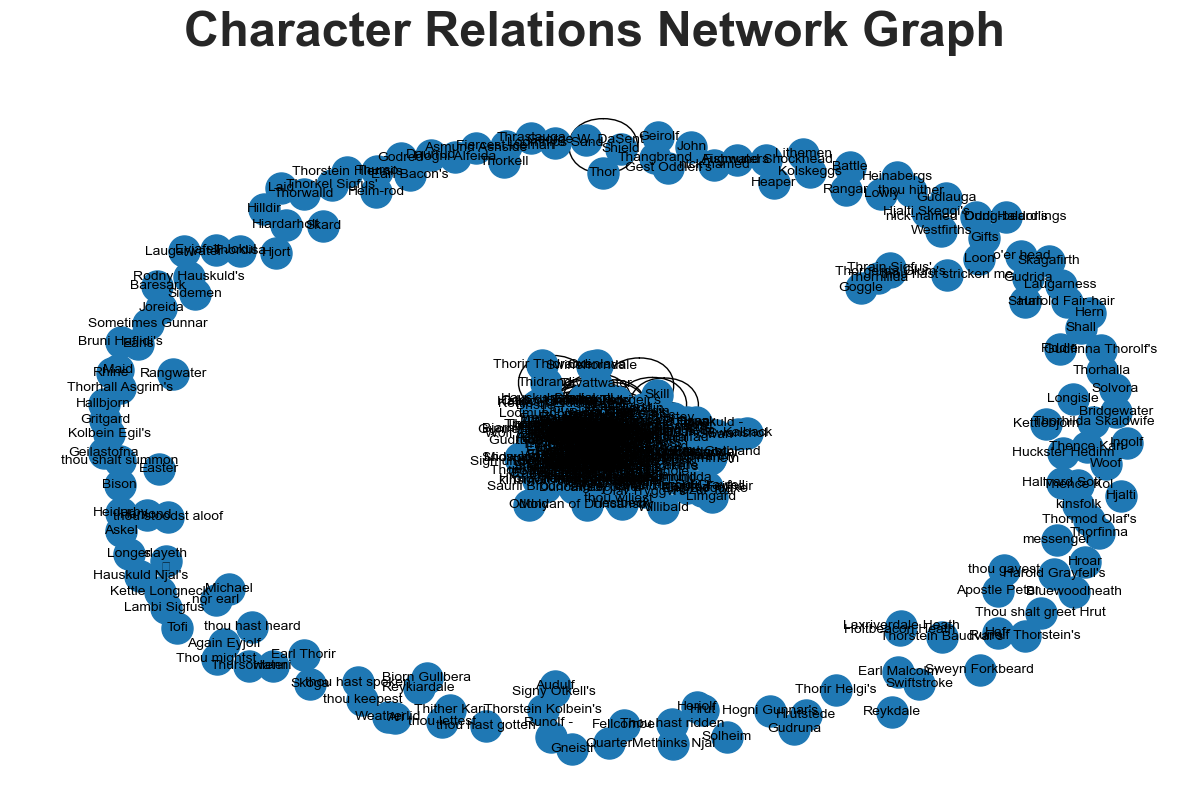

In [46]:
pos = nx.spring_layout(G, seed=42)  # Adjust layout algorithm as needed

plt.figure(figsize=(12, 8))
nx.draw_networkx(G, pos, with_labels=True, node_size=500, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title('Character Relations Network Graph')
plt.axis('off')
plt.tight_layout()
plt.show()